In [1]:
%pip install dictlearn

In [2]:
from dictlearn import DictionaryLearning, methods
from matplotlib import image
from matplotlib import pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.preprocessing import normalize
from sklearn.linear_model import orthogonal_mp
import numpy as np

In [3]:
p=8 #dimensiunea unui patch
s=6 #sparsitatea
N=1000 #nr total de patch-uri
n=256 #nr de atomi din dictionar
K=50 #nr de iteratii DL
sigma=0.075 #deviatia standard a zgomotului

**1. Pregatirea imaginii**

a) Incarcati imaginea.

b) Adaugati zgomot cu dispersie sigma imaginii

c) Extrageti patch-urile din imaginea Inoisy si memoratile in variabila Ynoisy. Vectorizati patch-urile. Afisati dimensiunea lui Ynoisy inainte si dupa vectorizare pentru a observa diferenta. Transpuneti matricea si calculati media semnalelor pe linii (axa 0), reprezentand media patch-urilor si scadeti-o din Ynoisy

d) Selectati N patch-uri de dimensiune p la intamplare din imagine obtinand semnalele Y

In [4]:
I = image.imread('image.png')
Inoisy = I + sigma * np.random.randn(I.shape[0],I.shape[1], I.shape[2])
print(Inoisy.shape)

(1964, 1965, 4)


In [5]:
patch_size=(p,p)
Ynoisy=extract_patches_2d(Inoisy,patch_size)
print(Ynoisy.shape)

(3831806, 8, 8, 4)


In [6]:
Ynoisy = Ynoisy.reshape(Ynoisy.shape[0], -1)
print(Ynoisy.shape)

(3831806, 256)


In [7]:
Ynoisy_tr=np.transpose(Ynoisy)
mean_patch=np.mean(Ynoisy_tr, axis=0)
#Ynoisy=Ynoisy-mean_patch

In [8]:
indices = np.random.choice(Ynoisy.shape[1], N)
Y = Ynoisy[indices]
print("Dimensiunea matricei cu patch-uri selectate:", Y.shape)

Dimensiunea matricei cu patch-uri selectate: (1000, 256)


**2. Antrenarea dictionarului**

a) Generati un dictionar aleator si normati coloanele obtinand dictionarul D0

b) Andrenati dictionarul D pornind de la dictionarul D0 initializat mai sus, in K iteratii utilizand patch-urile selectate Y ca semnale de antrenare

In [9]:
D0=np.random.rand(p**2,n)
D0 = normalize(D0, axis=0, norm='max')
#print(D0.shape)
D0 = np.resize(D0, (Y.shape[0], n))

In [ ]:
d1=DictionaryLearning(
    n_components=n,
    max_iter=K,
    fit_algorithm='ksvd',
    n_nonzero_coefs=s,
    code_init=None,
    dict_init=D0,
    params=None,
    data_sklearn_compat=False
)
d1.fit(Y)


In [11]:
D = d1.D_
#print(D)

**3. Calcularea reprezentarii rare si reconstructia imaginii**

a) Calculati reprezentarea rara a semnalelor Ynoisy -> Xc

b) Obtineti patch-urile curate Yc utilizand dictionarul D si reprezentarea Xc, apoi adaugati media pe linii pe care ati scazut-o anterior

c) Reconstruiti imaginea din patch-urile Yc, obtinand imaginea curata Ic

In [12]:
#Pentru a functiona functia omp a trebuit sa dau reshape la Ynoisy pentru a avea aceeasi forma cu D (anume 1000,256)
indices = np.random.choice(Ynoisy.shape[1], N)
Yn = Ynoisy[indices]

Xc, err =methods.omp(Yn, D, n_nonzero_coefs=s)

In [13]:
Yc = np.dot(Xc, D.T)
#Yc=Yc+mean_patch
print(Yc.shape)

(256, 1000)


In [17]:
Yc = Yc.reshape((N, p, p, -1))
print(Yc.shape)

(1000, 8, 8, 4)


In [18]:
Ic = reconstruct_from_patches_2d(Yc, (I.shape[0], I.shape[1], I.shape[2]))

**4. Evaluare performantei**

a) Vizualizati cele 3 imagini (originala, alterata de zgomot si curatata de zgomot)

b) Calculati *psnr* pentru a masura reducerea zgomotului. Calculati atat
psnr intre imaginea originala si cea afectata de zgomot, cat si intre
cea originala si cea in care ati eliminat zgomotul

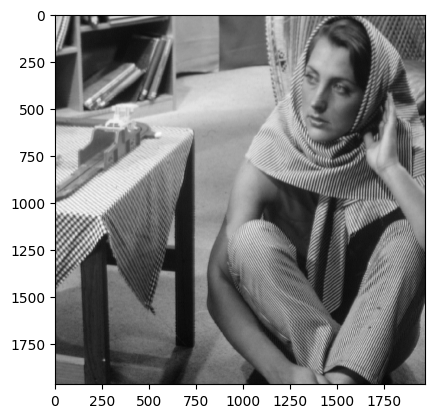

In [20]:
plt.imshow(I)

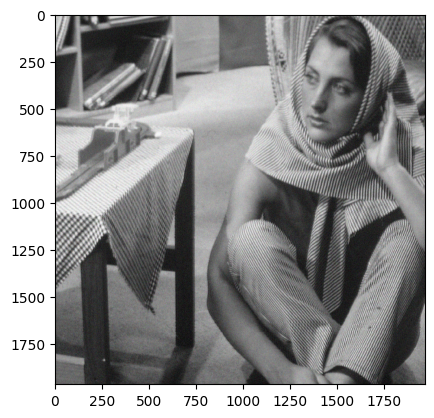

In [21]:
plt.imshow(Inoisy)

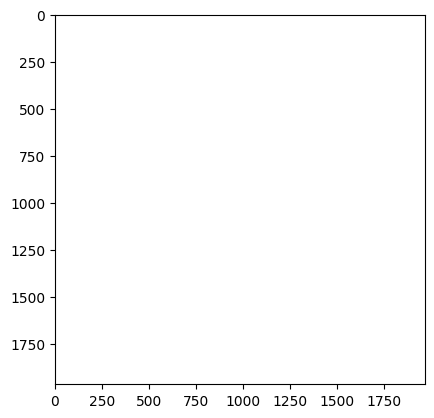

In [19]:
plt.imshow(Ic)

In [22]:
def psnr(img1,img2):
  mse=np.mean((img1-img2)**2)
  if(mse==0):
    return 0
  max_pixel=255
  psnr=20*np.log10(max_pixel/ np.sqrt(mse))
  return psnr

In [25]:
psnr12=psnr(I,Inoisy)
print(psnr12)

70.62793866176311


In [24]:
psnr23=psnr(Inoisy,Ic)
print(psnr23)

51.60990966554369
